In [1]:
import pandas as pd
import requests
import numpy as np
import os
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid", color_codes=True)

In [3]:
from src.util_download_yields import *

In [4]:
%matplotlib inline

# CONSTANTS, CONFIGS

In [5]:
MIN_YEAR = 2010
MAX_YEAR = 2014
TEST_SPLIT = MAX_YEAR
YIELD_FOLDER = '../data/yield/'
YIELD_FILE =  '../data/yield/yield_raw_data_all.csv'
PROCESSED_YIELD_FILE = "../data/yield/yield_proc_data.csv"
PROCESSED_YIELD_WEATHER_FILE =  "../data/yield/yield_toAnalysis_data.csv"
# NASS_API_KEY = ''

# Build and download NASS Barley data

In [6]:
def load_weather(file_name):
    df = pd.read_csv(file_name)
    df.dropna(axis=0,how='all',inplace=True)
    df.dropna(axis=1,how='all',inplace=True)
    return df

In [7]:
def load_clean(file_name):
    df = pd.read_csv(file_name)
    df.dropna(axis=0,how='all',inplace=True)
    df.dropna(axis=1,how='all',inplace=True)  
    return df

# Process and save file

In [8]:
print MIN_YEAR, MAX_YEAR, YIELD_FOLDER

2010 2014 ../data/yield/


In [9]:
df_state = get_gov_yield(MIN_YEAR, MAX_YEAR)

<Response [200]>


In [10]:
df_state.to_csv(YIELD_FILE)
YIELD_FILE

IOError: [Errno 2] No such file or directory: '../data/yield/yield_raw_data_all.csv'

In [11]:
df_state.head()

,asd_desc,county_name,state_alpha,year,cyield,irig_flag
514,NORTHEAST,BOULDER,CO,2010,91.7,1
516,NORTHEAST,LARIMER,CO,2012,92.4,1
517,NORTHEAST,LARIMER,CO,2011,110.0,1
518,NORTHEAST,LARIMER,CO,2010,95.9,1
520,NORTHEAST,WELD,CO,2012,75.4,0


In [12]:
df_state.state_alpha.unique()

array([u'CO', u'ID', u'MT', u'WY'], dtype=object)

In [13]:
df_state = df_state.loc[(df_state['state_alpha'] == 'CO')]

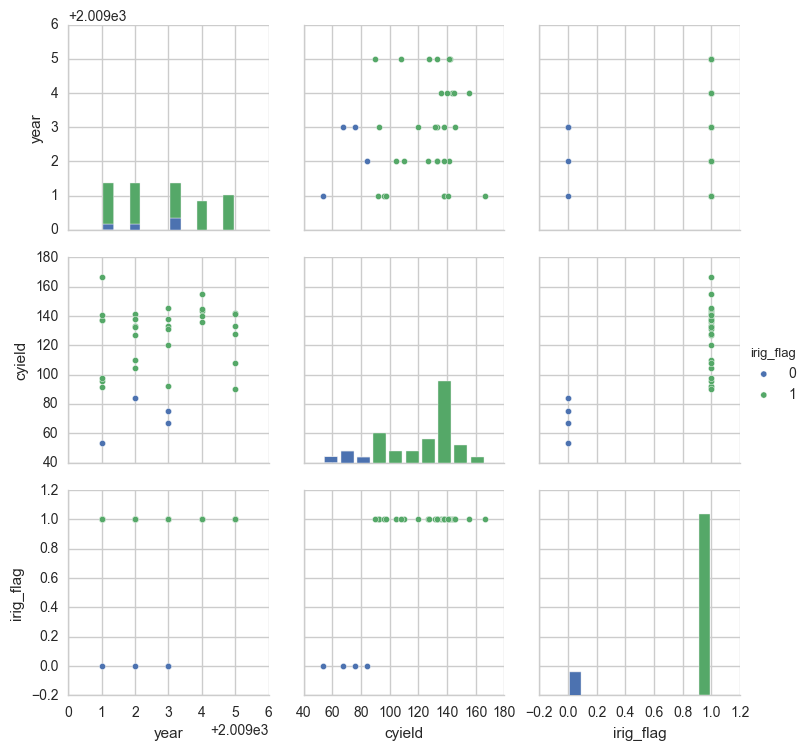

In [17]:
g = sns.pairplot(df_state,hue='irig_flag') #, palette='pastel')

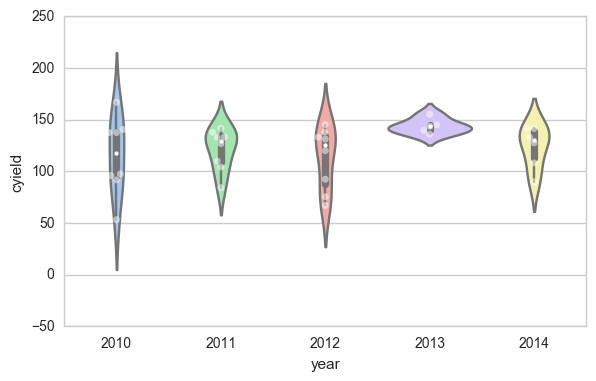

In [15]:
g = sns.violinplot(x='year',y='cyield',col='asd_desc', kind='box', data=df_state, size=4, lw=1, alpha=0.5, palette='pastel')
g = sns.swarmplot(x='year',y='cyield', data=df_state, color='w', alpha=0.5)

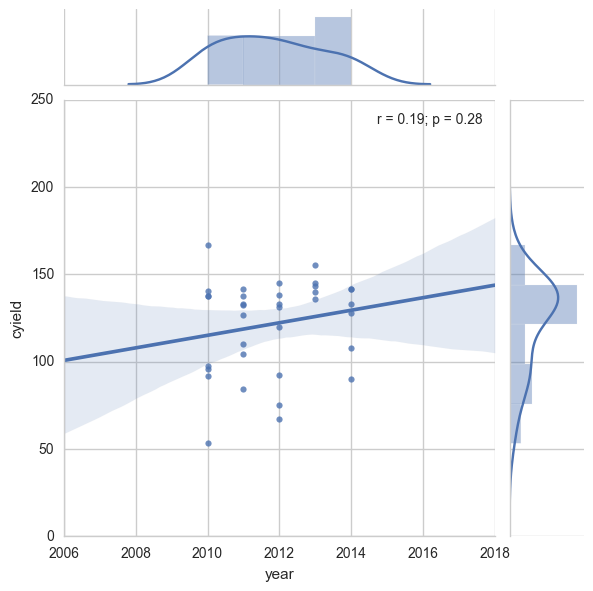

In [16]:
g = sns.jointplot(x='year',y='cyield',data=df_state, kind='reg',annot_kws=dict(stat="r"))

In [17]:
df_dummies_state = pd.get_dummies(df_state)
df_state.head(2)

,asd_desc,county_name,state_alpha,year,cyield,irig_flag
514,NORTHEAST,BOULDER,CO,2010,91.7,1
515,NORTHEAST,LARIMER,CO,2016,97.5,1


In [18]:
y= df_state.pop('cyield')

In [19]:
# Fit OLS
X = sm.add_constant(df_state.year)
ols = sm.OLS(y, X)
model = ols.fit()
b0, b1 = model.params.const, model.params.year
print model.summary().as_text()

                            OLS Regression Results                            
Dep. Variable:                 cyield   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.3994
Date:                Wed, 01 Mar 2017   Prob (F-statistic):              0.532
Time:                        18:59:54   Log-Likelihood:                -163.75
No. Observations:                  37   AIC:                             331.5
Df Residuals:                      35   BIC:                             334.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -2254.4472   3768.915     -0.598      0.5

# Check influnce plots....
 look good within the "+/-3" range

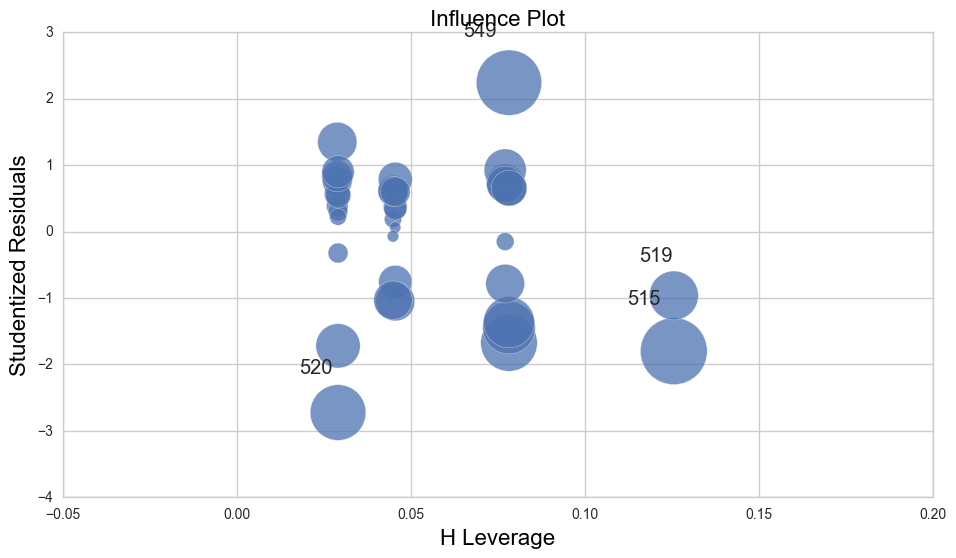

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(model,ax=ax)

## QQ plot a slight bit concerning at low end

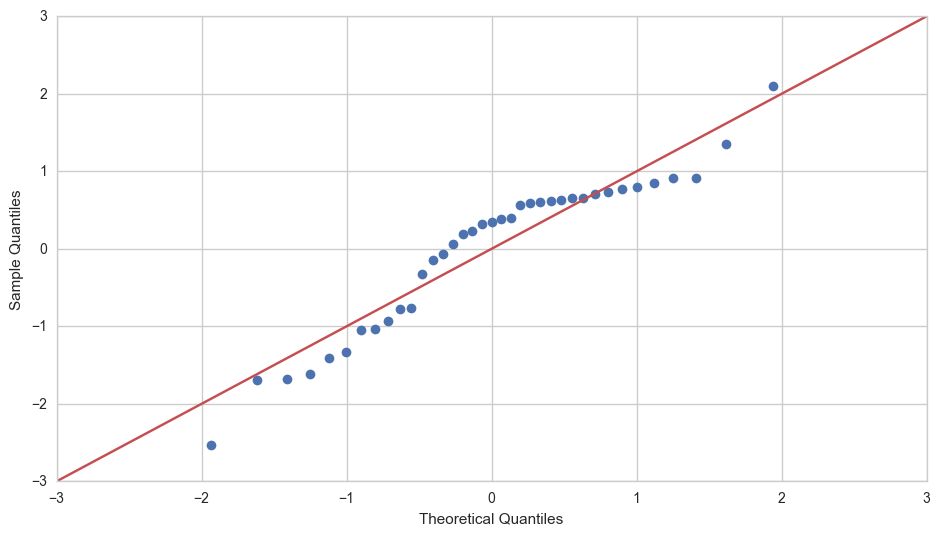

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.qqplot(model.resid, stats.t, fit=True, line='45',ax=ax)

# Plot how well it predicted 

In [22]:
df_xx = pd.DataFrame()
df_xx['region'] = df_state['asd_desc']
df_xx['y_true'] = pd.to_numeric(y)
df_xx['y_yr_ols'] = model.fittedvalues

### Plot regression vs. predicted

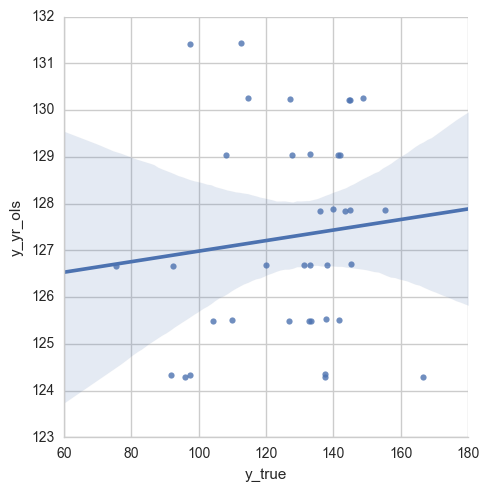

In [23]:
sns.lmplot(x='y_true',y='y_yr_ols',data=df_xx,y_jitter=.03)

### Check the residuals
residuals look random

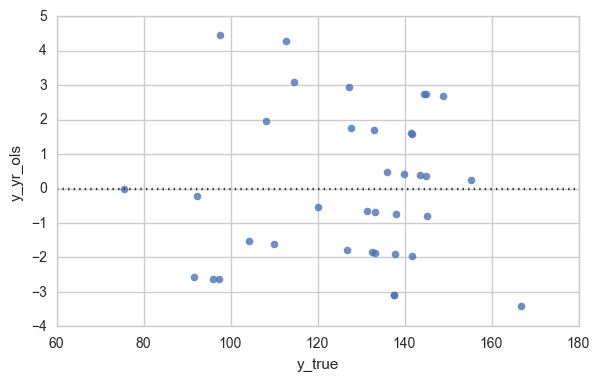

In [24]:
sns.residplot(x='y_true',y='y_yr_ols',data=df_xx,scatter_kws={"s": 30})

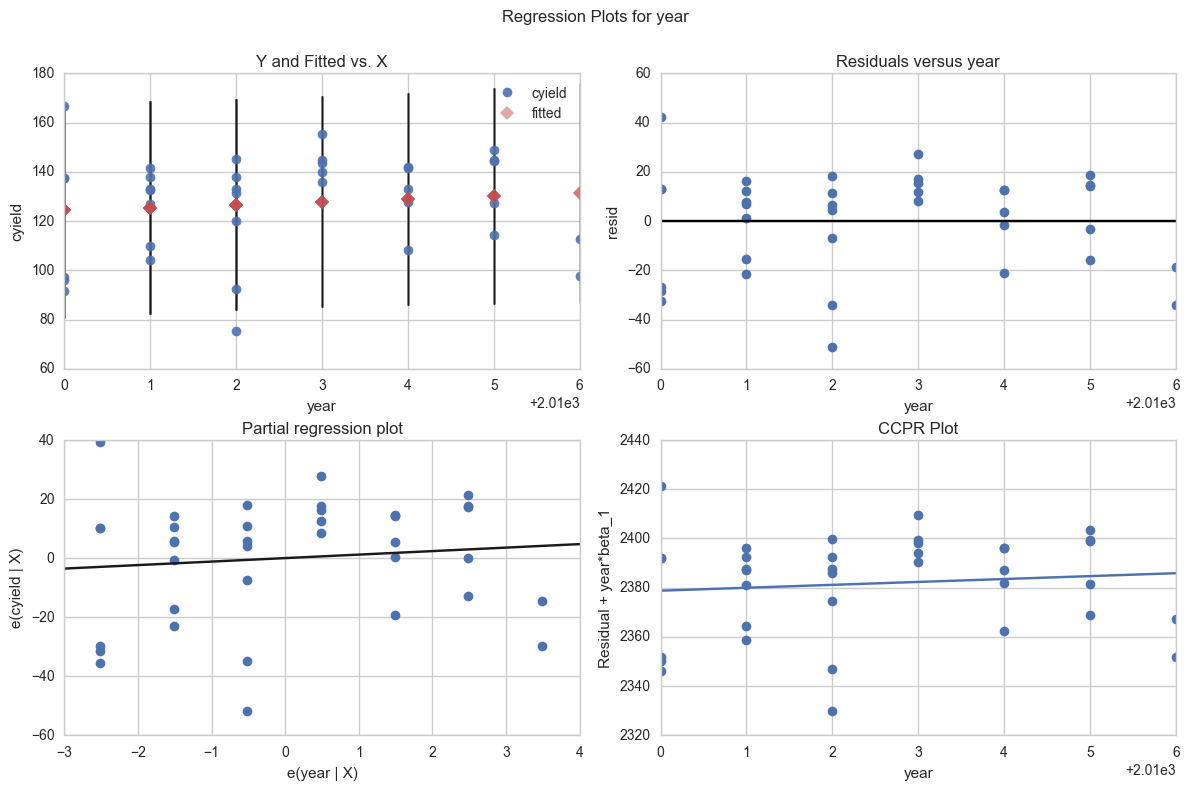

In [25]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'year', fig=fig)

# ===========================================

## DONE WITH EDA ON THE STATE YIELDS

## Next step combine the yield data with weather data